# Анализ данных сервиса аренды самокатов GoFast

В нашем распоряжении данные о поездках и пользователях сервиса аренды самокатов GoFast. Перед нами стоит задача, на основании имеющихся датафреймов сделать выводы, которые в будущем помогут компании лучше понимать клиентов и сделать полезные выводы для улучшения бизнеса. Итоговой целью будет проверка нескольких гипотез. <br/>
<br/>
Действовать будем по такому плану:
* загрузим имеющиеся датайремы и посмотрим, какие данные у нас имеются
* обработаем полученные таблицы, проверим наличие пропусков и устраним их. Приведем данные к такому виду, чтобы с ними было удобно работать
* изучим основные характеристики, которые могут помочь нам в дальнейшем, визуализируем их представление
* создадим общий датафрейм со всеми данными и добавим несколько новых столбцов с важными расчетами.
* проверим поставленные гипотезы
* поможем понять бизнесу как эффективнее привлечь новых клиентов

In [2]:
import pandas as pd
import warnings
warnings.simplefilter("ignore") 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom

### Шаг 1. Загрузка данных

In [4]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
display(users.head(10))
print()
display(rides.head(10))
print()
subscriptions

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [3]:
print(users.info())
print()
print(rides.info())
print()
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 column

Из того что можно сразу отметить: в датафреймах нет пропусков, все целые числа уже имеют тип int, названия столбцов корректны и подчиняются внегласным правилам наименования столбцов. <br/>
Единственное, что сразу бросается в глаза, это формат времени. Его мы позже изменим.

#### Шаг 2. Предобработка данных

In [4]:
#Изменения типа данных в столбце с датами.
rides['date'] = pd.to_datetime(rides['date'], format = '%Y-%m-%d')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [5]:
#создадим колонку с номером месяца
rides['month'] = rides['date'].dt.month

In [6]:
#Проверим наличие дубликатов в столбцах во всех датафреймах
print(users.duplicated().sum())
print(rides.duplicated().sum())
print(subscriptions.duplicated().sum())

31
0
0


Дубликаты найдены только в датафрейме с пользователями. Надо будет удалить их, а так же не забыть обновить индексы

In [7]:
users = users.drop_duplicates().reset_index(drop=True)
#снова сделаем проверку на наличие явных дубликатов
users.duplicated().sum()

0

Теперь можно быть увереным, что все явные дубликаты устранены.

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов;

In [8]:
users.groupby('city')['user_id'].count().sort_values(ascending = False)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: user_id, dtype: int64

Для того чтобы отобразить частоту встречаемости городов, мы также выведем гистограмму частот для наглядности.

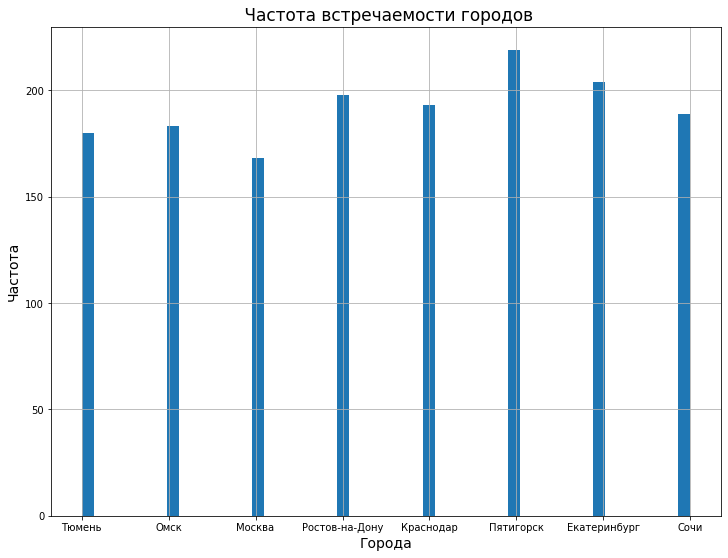

In [9]:
users['city'].hist( bins = 50, figsize = (12,9))
plt.title(' Частота встречаемости городов', size = 17)
plt.xlabel('Города', size = 14)
plt.ylabel('Частота', size = 14)
plt.show()

По ней хорошо видно, что больше всего данных у нас из городов Пятигорск, Екатеринбург и Ростов-на-дону - около 200. Остальных значений очень близкое количество, так что различия малы.

##### Cоотношение пользователей с подпиской и без подписки;


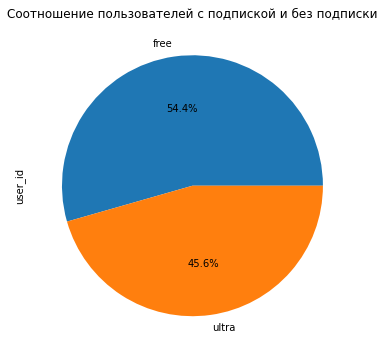

subscription_type
free     835
ultra    699
Name: user_id, dtype: int64

In [10]:
users.groupby('subscription_type')['user_id'].count().plot(kind = 'pie',figsize = (6,6), autopct='%1.1f%%')
plt.title('Cоотношение пользователей с подпиской и без подписки')
plt.show()
users.groupby('subscription_type')['user_id'].count()

На графике явно видно, что пользователей с подпиской и без почти 50/50, но бесплатных подписок все равно больше.

##### Возраст пользователей


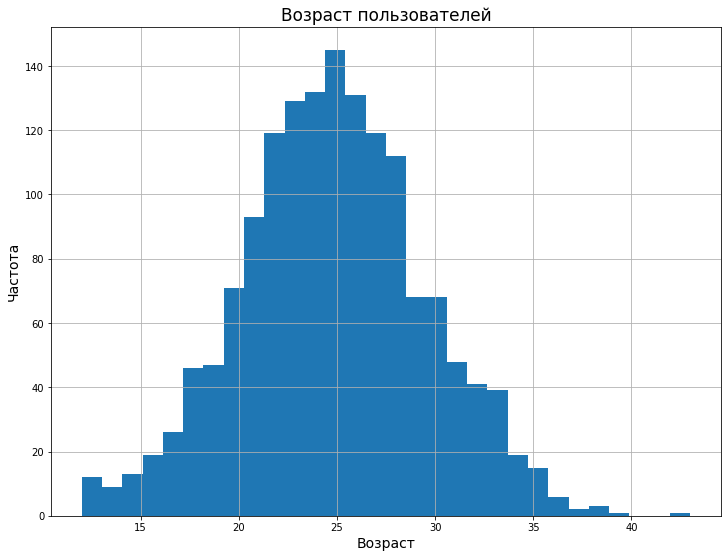

In [11]:
users['age'].hist(bins = 30, figsize = (12,9))
plt.title('Возраст пользователей', size = 17)
plt.xlabel('Возраст', size = 14)
plt.ylabel('Частота', size = 14)
plt.show()

По графику можно отчетливо заметить, что распределение возрастов пользователей очень близко к нормальному виду. Самый пик приходится на 25 лет. Но так же имеются значения и меньше 5 лет, и больше 45. 

##### Расстояние, которое пользователь преодолел за одну поездку

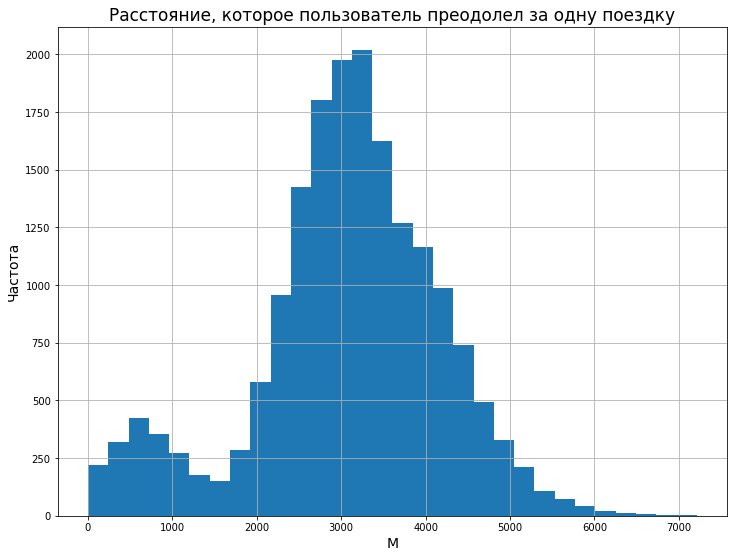

In [12]:
rides['distance'].hist(bins = 30, figsize = (12,9))
plt.title('Расстояние, которое пользователь преодолел за одну поездку', size = 17)
plt.xlabel('М', size = 14)
plt.ylabel('Частота', size = 14)
plt.show()

Мы получили график распределения киллометража поездки. Он имеет почти нормальный вид, за исключением области до 1.5км. Видимо есть один тип пользователей, которые берут просто попробовать покататься, и есть пользователи которые берут уже на более долгую прогулку. В таких случаях, самой частой дистанцией выступают значения от 3 до 3.5 км.

##### Продолжительность поездок

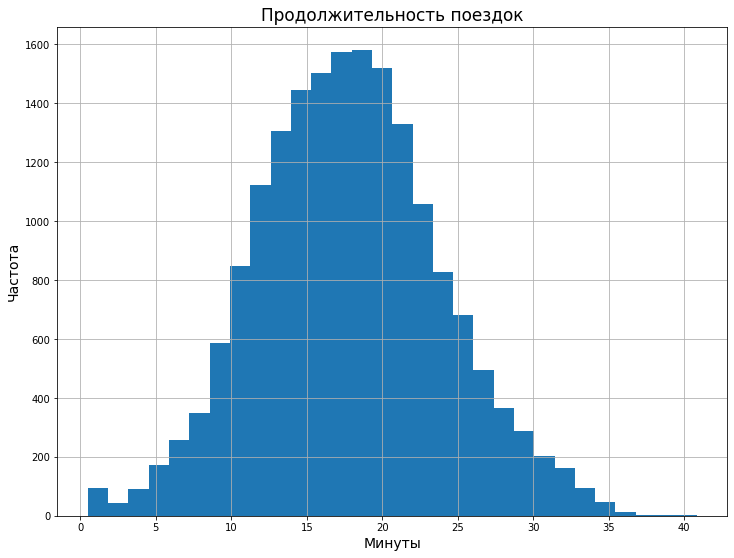

Минимальная продолжительность: 0.5
Максимальная продолжительность: 40.82396261922424


In [13]:
rides['duration'].hist(bins = 30, figsize = (12,9))
plt.title('Продолжительность поездок' ,size = 17)
plt.xlabel('Минуты', size = 14)
plt.ylabel('Частота', size = 14)
plt.show()

print('Минимальная продолжительность:', rides['duration'].min())
print('Максимальная продолжительность:', rides['duration'].max())

Мы вновь получили нормальное распределение, с центром в значении около 17 минут. Значит это самая распространенная продолжительность, а остальные значения стремятся к нему. Так же были получены значения максимума и минимума. Пользователи проводили в поездке от 0.5 до 40 минут.

#### Шаг 4. Объединение данных

##### Объединение 3 датафремов в 1

In [14]:
#объединим 3 датафрейма в один
data = users.merge(rides, on = 'user_id', how = 'outer')
data = data.merge(subscriptions, on = 'subscription_type', how = 'outer')
print(data.head(10))

   user_id  name  age    city subscription_type     distance   duration  \
0        1  Кира   22  Тюмень             ultra  4409.919140  25.599769   
1        1  Кира   22  Тюмень             ultra  2617.592153  15.816871   
2        1  Кира   22  Тюмень             ultra   754.159807   6.232113   
3        1  Кира   22  Тюмень             ultra  2694.783254  18.511000   
4        1  Кира   22  Тюмень             ultra  4028.687306  26.265803   
5        1  Кира   22  Тюмень             ultra  2770.890808  16.650138   
6        1  Кира   22  Тюмень             ultra  3039.020292  14.927879   
7        1  Кира   22  Тюмень             ultra  2842.118050  23.117468   
8        1  Кира   22  Тюмень             ultra  3412.690668  15.238072   
9        1  Кира   22  Тюмень             ultra   748.690645  15.041884   

        date  month  minute_price  start_ride_price  subscription_fee  
0 2021-01-01      1             6                 0               199  
1 2021-01-18      1           

In [15]:
#теперь удостоверимся, что объединение прошло успешно и сравним размер исходных датафреймов и получившихся
print(users.info())
print(rides.info())
# Самая большая таблица получается rides, там 18068 строк. Получается, что в итоговом датафрейме data должно получится такое же количество строк
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB
None
<cl

Количество строк в итоговом датафрейме совпадает с количеством строк в самом большом из трех объединенных датафреймов, а это значит, что все прошло успешно, можем двигаться дальше.

##### Создание отдельных датафреймов для пользователей с подпиской и без

In [16]:
#Создадим 2 отдельных датафрейма с пользователями у которых есть подписка ultra и без нее.
data_ultra = data.query('subscription_type == "ultra"')
data_free = data.query('subscription_type == "free"')
print(data_ultra.head(10))
print(data_free.head(10))

   user_id  name  age    city subscription_type     distance   duration  \
0        1  Кира   22  Тюмень             ultra  4409.919140  25.599769   
1        1  Кира   22  Тюмень             ultra  2617.592153  15.816871   
2        1  Кира   22  Тюмень             ultra   754.159807   6.232113   
3        1  Кира   22  Тюмень             ultra  2694.783254  18.511000   
4        1  Кира   22  Тюмень             ultra  4028.687306  26.265803   
5        1  Кира   22  Тюмень             ultra  2770.890808  16.650138   
6        1  Кира   22  Тюмень             ultra  3039.020292  14.927879   
7        1  Кира   22  Тюмень             ultra  2842.118050  23.117468   
8        1  Кира   22  Тюмень             ultra  3412.690668  15.238072   
9        1  Кира   22  Тюмень             ultra   748.690645  15.041884   

        date  month  minute_price  start_ride_price  subscription_fee  
0 2021-01-01      1             6                 0               199  
1 2021-01-18      1           

Получили 2 отдельных датафрейма для пользователей с подпиской и без.

##### Теперь визуализируем расстояние и время поездок для пользователей обоих категорий

Информация о дальности поездок с подпиской:
 count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

Информация о дальности поездок без подписки:
 count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64


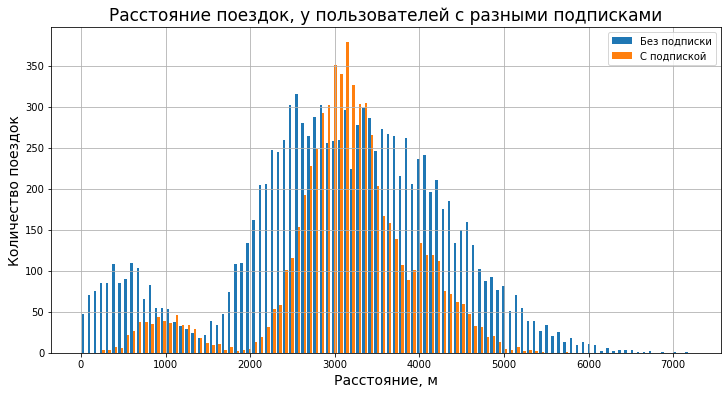

In [17]:
#Для начала получим наглядные данные в цифрах.
#Рассмотрим дистанцию
print('Информация о дальности поездок с подпиской:\n',data_ultra['distance'].describe())
print()
print('Информация о дальности поездок без подписки:\n',data_free['distance'].describe())
plt.figure(figsize =(12,6))
plt.hist([data_free['distance'], data_ultra['distance']], bins = 100)
plt.legend(['Без подписки', 'С подпиской'])
plt.xlabel('Расстояние, м', size = 14)
plt.ylabel('Количество поездок', size = 14)
plt.title('Расстояние поездок, у пользователей с разными подписками', size = 17)
plt.grid()
plt.show()

По данному графику можно сказать, что оба распределения имеют вид довольно близкий к нормальному, за исключением области до 1.5 км. А так, заметно, что у пользователей без подписки больший разброс по расстоянию, а у людей с подпиской более выражено среднее значение, равное чуть больше 3 км. Пользователи без подписки чаще всего проезжают от 2.5 до 3.5 км.

Информация о продолжительности поездок без подписки:
 count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

Информация о продолжительности поездок с подпиской:
 count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64


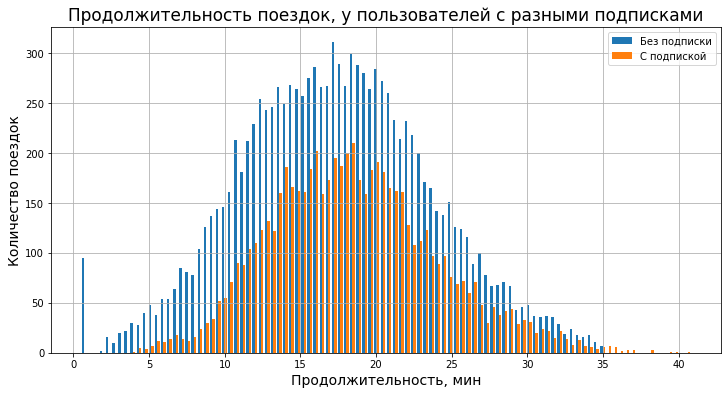

In [18]:
#Теперь выведем график для продолжительности
print('Информация о продолжительности поездок без подписки:\n',data_free['duration'].describe())
print()
print('Информация о продолжительности поездок с подпиской:\n',data_ultra['duration'].describe())
plt.figure(figsize =(12,6))
plt.hist([data_free['duration'], data_ultra['duration']], bins = 100)
plt.legend(['Без подписки', 'С подпиской'])
plt.xlabel('Продолжительность, мин', size = 14)
plt.ylabel('Количество поездок', size = 14)
plt.title('Продолжительность поездок, у пользователей с разными подписками', size = 17)
plt.grid()
plt.show()

По этому графику за исключением 1 выброса около нуля можно с уверенностью сказать что продолжительность поездок у обоих категорий распределена нормально. Очень близки показатели разброса, да и в целом, можно сказать что будь пользователей поровну, то графики наложились один на другой. Значит, продолжительность поездки не особо зависит от типа подписки


#### Шаг 5. Подсчёт выручки

##### Создадим датафрейм в котором объединим данные по пользователям

In [19]:
#сперва округлим значения времени до большего целого
data['duration'] = np.ceil(data['duration'])
#а так же сразу поменяем тип переменных на int
#data['duration'] = data['duration'].astype('Int64', errors = 'ignore')

In [20]:
#Теперь создадим таблицу с информацией по каждому пользователю
data_sum = data.groupby(['user_id','month'])['duration','distance'].agg(sum)

data_sum['count'] = data.groupby(['user_id','month'])['duration'].agg('count')
data_sum


duration      distance  count
user_id month                               
1       1          42.0   7027.511294      2
        4           7.0    754.159807      1
        8          46.0   6723.470560      2
        10         32.0   5809.911100      2
        11         56.0   7003.499363      3
...                 ...           ...    ...
1534    6          26.0   3409.468534      2
        8          48.0   7622.453034      2
        9          23.0   4928.173852      1
        11         78.0  13350.015305      4
        12         16.0   2371.711192      1

[11331 rows x 3 columns]

##### Добавление столбца с информацией о прибыли, которую принес каждый пользователь в месяц

In [21]:
#для удобства добавим в датафрейм информацию о стоимости минуты, старта и подписки
data_sum = data_sum.merge(data[['user_id','minute_price','start_ride_price','subscription_fee']], on = 'user_id', how = 'outer').drop_duplicates().reset_index(drop = True)
data_sum

,user_id,duration,distance,count,minute_price,start_ride_price,subscription_fee
0,1,42.0,7027.511294,2,6,0,199
1,1,7.0,754.159807,1,6,0,199
2,1,46.0,6723.470560,2,6,0,199
3,1,32.0,5809.911100,2,6,0,199
4,1,56.0,7003.499363,3,6,0,199
...,...,...,...,...,...,...,...
11326,1534,26.0,3409.468534,2,8,50,0
11327,1534,48.0,7622.453034,2,8,50,0
11328,1534,23.0,4928.173852,1,8,50,0
11329,1534,78.0,13350.015305,4,8,50,0


In [22]:
#добавление колонки с помесячной выручкой
data_sum['revenue'] = data_sum['start_ride_price']*data_sum['count']+data_sum['minute_price']*data_sum['duration']+data_sum['subscription_fee']
data_sum

,user_id,duration,distance,count,minute_price,start_ride_price,subscription_fee,revenue
0,1,42.0,7027.511294,2,6,0,199,451.0
1,1,7.0,754.159807,1,6,0,199,241.0
2,1,46.0,6723.470560,2,6,0,199,475.0
3,1,32.0,5809.911100,2,6,0,199,391.0
4,1,56.0,7003.499363,3,6,0,199,535.0
...,...,...,...,...,...,...,...,...
11326,1534,26.0,3409.468534,2,8,50,0,308.0
11327,1534,48.0,7622.453034,2,8,50,0,484.0
11328,1534,23.0,4928.173852,1,8,50,0,234.0
11329,1534,78.0,13350.015305,4,8,50,0,824.0


Мы получили таблицу, в которой есть колонка, отображающая помесячную выручку от каждого пользователя. Теперь мы можем визуализировать эти данные и посмотреть, как влияет тип подписки на то, сколько пользователи тратят денег.

Информация о прибыли в месяц без подписки:
 count    6798.000000
mean      328.641365
std       183.868330
min        58.000000
25%       194.000000
50%       274.000000
75%       428.000000
max      1444.000000
Name: revenue, dtype: float64

Информация о прибыли в месяц с подпиской:
 count    4533.000000
mean      362.792191
std        88.262737
min       223.000000
25%       301.000000
50%       337.000000
75%       409.000000
max       955.000000
Name: revenue, dtype: float64


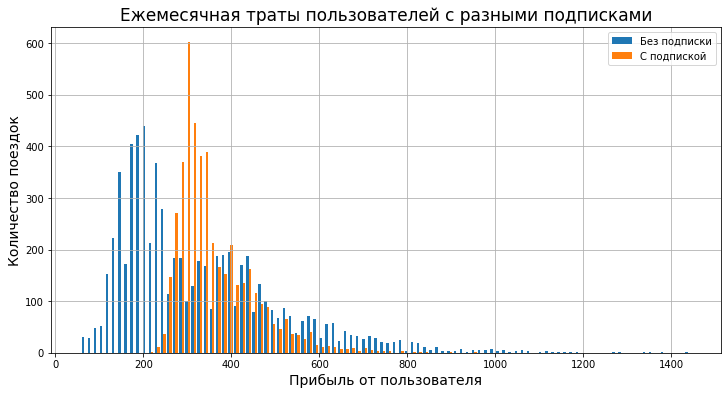

In [23]:
#для того чтобы визуализировать данные я снова создам 2 датафрейма для пользователей с подпиской и без
data_free2 = data_sum.query('start_ride_price == 50').reset_index(drop = True)
data_ultra2 = data_sum.query('start_ride_price == 0').reset_index(drop = True)
print('Информация о прибыли в месяц без подписки:\n',data_free2['revenue'].describe())
print()
print('Информация о прибыли в месяц с подпиской:\n',data_ultra2['revenue'].describe())
plt.figure(figsize =(12,6))
plt.hist([data_free2['revenue'], data_ultra2['revenue']], bins = 100)
plt.legend(['Без подписки', 'С подпиской'])
plt.xlabel('Прибыль от пользователя', size = 14)
plt.ylabel('Количество поездок', size = 14)
plt.title('Ежемесячная траты пользователей с разными подписками', size = 17)
plt.grid()
plt.show()

На этом графике наглядно видно, что распределения имеют похожий вид, но пиковые значения графика пользователей с подпиской смещены в право. Это значит, что основная часть людей, у которых есть подписка, тратят в месяц больше, чем те, у кого подписки нет. Если взглянуть на значение среднего, то оно тоже больше у пользователей с подпиской, хоть и не на много.

#### Шаг 6. Проверка гипотез

##### Проверка гипотезы о том, что пользователи с подпиской тратят больше времени на поездки

За нулевую гипотезу возьмем утверждение, что среднее время поездки пользователей с обоими типов подписки равны между собой.<br/>
Альтернативная гипотеза будет звучать так: среднее время у пользователей с подпиской больше чем среднее время пользователей на бесплатном тарифе.

In [24]:
alpha = 0.05
results = st.ttest_ind(data_ultra['duration'], data_free['duration'], equal_var = False, alternative = 'greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 5.6757813771289775e-37
Отвергаем нулевую гипотезу


В данном пункте мы проверяли гипотезу о равенстве средних при помощи t-теста, в котором играет значение, равны ли дисперсии обоих выборок между собой или нет. Так как исследуемые выборки разного размера, как мы это выяснили ранее, то есть основания полагать что дисперсии скорее всего разные. Поэтому аргумент в equal_var выставлен как False.

Нулевая гипотеза отвергнута, а это значит, что скорее всего альтернативная гипотезу, говорящая о том что пользователи с подпиской тратят больше времени на поездку мы примем как наиболее вероятную.

##### Проверка гипотезы о том, что среднее расстояние поездки пользователя с подпиской не превышает 3130м

Нулевая гипотеза звучит так: Среднее расстояние, проезжаемое пользователем с подпиской ultra за один сеанс **равно** 3130м.<br/>
Альтернаятивная гипотеза: Среднее расстояние, проезжаемое пользователем с подпиской ultra за один сеанс **меньше** 3130м


In [25]:
interested_value = 3130 

results2 = st.ttest_1samp(data_ultra['distance'], interested_value, alternative = 'less')
print('p-значение:', results2.pvalue)

if results2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.08046311521502146
Не получилось отвергнуть нулевую гипотезу


Мы не смогли отвергнуть нулевую гипотезу, так как вероятность получить в среднем значении искомые 3130м - слишком велико. Мы не можем утверждать, что это неправда. Хочется в ручную проверить среднее значение и удостовериться в результате

In [26]:
print('Среднее значение равно:', data_ultra['distance'].mean())
print('Медианное значение равно:', data_ultra['distance'].median())

Среднее значение равно: 3115.4453880370247
Медианное значение равно: 3148.6372291760854


Мы действительно получили среднее значение очень близкое к 3130м, а медианное вообще больше этого значения. Значит мы действительно не можем опровергнуть гипотезу о том, что Среднее не равно 3130м. Будем считать, что так оно и есть. <br/>
В таком случае, можно сделать выводы, что расстояние, которое проезжают пользователи с подпиской, находится на грани оптимального расстояния. 

##### Проверка гипотезы о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Нулевая гипотеза будет звучать так: Средняя помесячная выручка у пользователей с подпиской и без равны. <br/>
Альтернативная: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

In [27]:
results3 = st.ttest_ind(data_ultra2['revenue'], data_free2['revenue'], equal_var = False, alternative = 'greater')
print('p-значение:', results3.pvalue)
if results3.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 8.874140893976874e-40
Отвергаем нулевую гипотезу


В данном пункте мы проверяли гипотезу о равенстве средних при помощи t-теста, в котором играет значение, равны ли дисперсии обоих выборок между собой или нет. Так как исследуемые выборки разного размера, как мы это выяснили ранее, то есть основания полагать что дисперсии скорее всего разные. Поэтому аргумент в equal_var выставлен как False.

Мы получили такое p-значение, что нулевая гипотеза точно отвергается. Выведем значения средних и сравним их

In [28]:
print('Среднее значение ежемесячной выручки с подпиской:', data_ultra2['revenue'].mean())
print('Среднее значение ежемесячной выручки без подписки:', data_free2['revenue'].mean())

Среднее значение ежемесячной выручки с подпиской: 362.7921906022502
Среднее значение ежемесячной выручки без подписки: 328.6413651073845


Теперь мы точно можем сделать выводы, что пользователи с подпиской приносят ежемесячно больше денег компании, чем без нее. Получается действительно, привлекать пользователей на покупку подписки это очень выгодное дело для прибыли компании.

##### Подбор теста для проверки гипотезы о количестве обращений в поддержку

В задании сказано, что надо проверить гипотезу, в которой будут сравниваться значения из 2 файлов, в которых есть данные для **каждого** пользователя о количестве сообщений до и после обновления сервера. Так как список пользователей остается одним и тем же, то можно сделать вывод что мы будем иметь дело с двумя **зависимыми** выборками, с одинаковым количеством записей. В таком случае будем использовать метод scipy.stats.ttest_rel. <br/>
Гипотеза будет являться **односторонней**, потому что нас интересует сдвиг значений именно в меньшую сторону.

#### Шаг 7. Распределения

##### Задача 1

In [29]:
#тут мы укажем искомое количество промокодов
n = 1000
p = 0.1 #вероятность удачного события

result2 = binom.cdf(100, n, p)
print('Вероятность получить менее 100 подписок:',result2)

Вероятность получить менее 100 подписок: 0.5265990812951653


При прочтении условия задания, самый очевидный ответ напрашивается - взять 1000 промокодов, ведь 10% от 1000 это и есть 100. Но как оказалось, у нас есть 50% вероятность попасть в промежуток меньше 100. А нам нужно добиться такого значения, чтобы этот процент был равен 5.

In [30]:
#создадим цикл, который будет перебирать значения n, пока не получит искомый процент неудач:

for i in range (0, 1000):
    n = 1000 + i
    mu = n*p #мат ожидание биномального распределения
    sigma = (n*p*(1-p))**0.5 #стандартное отклонение
    distr = st.norm(mu, sigma)
    if distr.cdf(100) < 0.05:
        print('Полученная вероятность получить значение меньше данного:', distr.cdf(100))
        print()
        print('Сколько промокодов надо отправить:', n)
        break

Полученная вероятность получить значение меньше данного: 0.04971489312694162

Сколько промокодов надо отправить: 1169


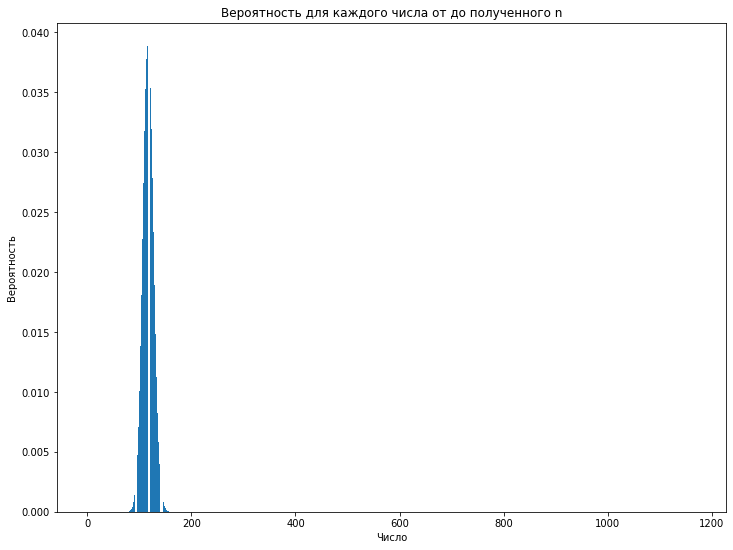

In [31]:
#Визуализируем полученную вероятность получить какое либо число от 1 до 1169 при нашей вероятности успеха в 10%
n2 = 1169 # количество попыток
p = 0.1 # вероятность успеха

distr = []

for k in range(0, n2 + 1):
    current_value = binom.pmf(k, n2, p)
    distr.append(current_value)
    
plt.figure(figsize = (12,9))    
plt.bar(range(0, n2 + 1), distr)
plt.title('Вероятность для каждого числа от до полученного n')
plt.xlabel('Число')
plt.ylabel('Вероятность')
plt.show()

По графику который мы получили видно, что большинство значений находятся правее чем 100, и это как раз выглядит как то, что слева остается 5%.

Мы автоматизировали способ подбора промокодов, и подсчитали количество промокодов, при котором мы с вероятностью 95% получим 100 оплаченных подписок после конца акции. <br/>
**Итог:** Нужно выдать 1169 промокодов.

##### Задача 2

В данной задаче от нас требуется построить примерный график распределения вероятностей с помощью аппроксимации. <br/>
Мы будем аппроксимировать с помощью нормального распределения

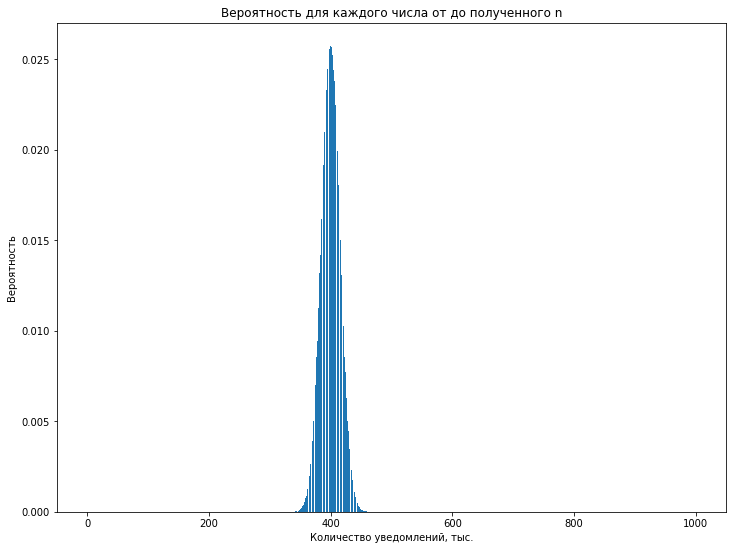

In [32]:
nn = 1000
pp = 0.4

row = []
for k in range(0, nn + 1):
    current_value = binom.pmf(k, nn, pp)
    row.append(current_value)
    
plt.figure(figsize = (12,9))    
plt.bar(range(0, nn + 1), row)
plt.title('Вероятность для каждого числа от до полученного n')
plt.xlabel('Количество уведомлений, тыс.')
plt.ylabel('Вероятность')
plt.show() 

На графике мы видим нормальное распределение, с пиком в 400 тысячах, что ожидаемо.Значит график верный. <br/>
Оценивать вероятность того, что уведомление откроют не более 399,5 тыс человек мы будем при помощи функции cdf

In [33]:
result2 = binom.cdf(399.5,nn,pp)
print('Вероятность получить не более 399.5 тыс. открытых уведомлений:',result2)

Вероятность получить не более 399.5 тыс. открытых уведомлений: 0.4879850394856607


Получается, вероятность того, что уведомление откроют не более 399.5 тыс. человек равна почти 48.8%

#### Вывод


Мы исследовали полученный датафрейм с данными о пользователях сервиса аренды самокатов GoFast из разных городов и сделали выводы насчет выгодности разных подписок, и можем составить портрет типичного пользователя. <br/><br/>
**Исходные данные**<br/><br/>
В данных не было пропусков, но встретилось несколько абсолютных дубликатов. Их количество было небольшим, и оно бы не сильно повлияло на дальнейшее исследование, поэтому было решено их просто удалить.<br/>
Также, для более удобного анализа мы объединили все три датафрейма в один общий, в котором получилась собрана абсолютна вся информация по каждой поездке, и сразу видно сколько она длилась, данные о пользователе и данные о тарифе, по которому она совершалась<br/><br/>
**Портрет среднестатистического пользователя**<br/><br/>
Больше всего данных у нас из городов Пятигорск, Екатеринбург и Ростов-на-дону.<br/>
Большая часть пользователей пользуется подпиской free<br/>
Средний возраст пользователя -  25 лет<br/>
Среднее расстояние за 1 поездку - 3.3км<br/>
Среднее время сеанса - 17 минут<br/>
<br/><br/>
**Выводы о прибыльности каждой из подписок**<br/><br/>
Человек с подпиской ultra ежемесячно приносит больше денег компании, чем пользователь который использует free подписку.<br/>
Продолжительность и дистанция маршрута не сильно зависит от типа подписки, но с небольшим отрывом показатели выше у пользователей с подпиской ultra.<br/>
Среднее значение ежемесячной выручки с подпиской: 362.8, а без подписки: 328.6. Получается, компании выгоднее проводить различные акции, которые в будущем увеличат количество пользователей которые купят подписку ultra.
